# Lab 3 — recommender systems

In [1]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pyspark.mllib.recommendation as rec
import pickle

from bokeh.plotting import figure, output_notebook,show, ColumnDataSource
from bokeh.models import HoverTool

from matplotlib.colors import rgb2hex

from operator import itemgetter


%matplotlib inline
plt.style.use("ggplot")
output_notebook()

Loading BokehJS ...

## 3.4 Basic statistics

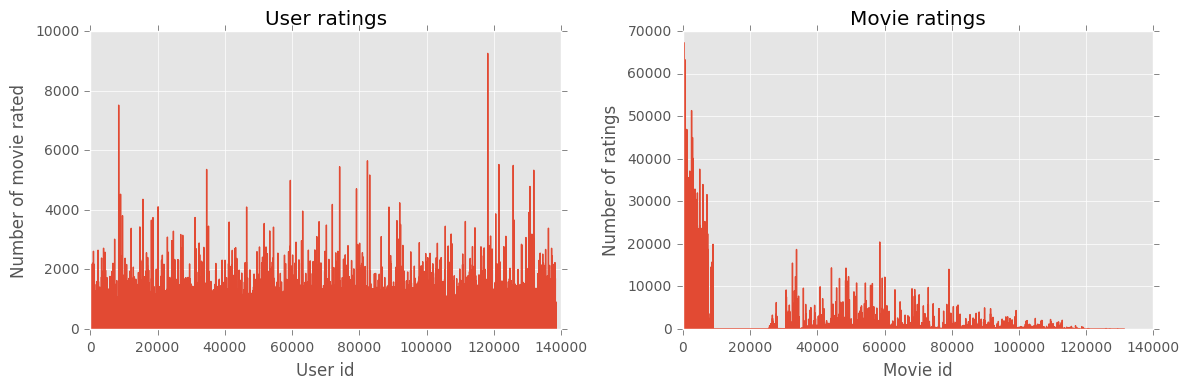

The mean of the number of rating per user is 144 and the variance is 53022
The mean of the number of rating per movie is 748 and the variance is 9521945


In [41]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

# We append our ratings to the ratings
myRatings = []
with open('my-ratings.txt','r') as file:
    for line in file:
        myRatings.append(json.loads(line))
myRatings = sc.parallelize(myRatings)
data = data.union(myRatings)

numRatings = data.count()

# We get the number of rating per user id
usersRatingCount = data.map(lambda rating: (rating['userId'],1)).countByKey().items()
usersRatingCount = list(zip(*usersRatingCount))
# We get the number of rating per movie id
moviesRatingCount = sorted(data.map(lambda rating: (rating['movieId'],1)).countByKey().items())
moviesRatingCount = list(zip(*moviesRatingCount))

# Plotting
fig, axes = plt.subplots(1,2,figsize=(12.0,4.0))

ax = axes[0]
ax.plot(*usersRatingCount)
ax.set_xlabel('User id')
ax.set_ylabel('Number of movie rated')
ax.set_title('User ratings')

ax = axes[1]
ax.plot(*moviesRatingCount)
ax.set_xlabel('Movie id')
ax.set_ylabel('Number of ratings')
ax.set_title('Movie ratings')
plt.tight_layout()
plt.show();
print("The mean of the number of rating per user is %.f and the variance is %.f"%(np.mean(usersRatingCount[1]),np.var(usersRatingCount[1])))
print("The mean of the number of rating per movie is %.f and the variance is %.f"%(np.mean(moviesRatingCount[1]),np.var(moviesRatingCount[1])))

We can see that the the number of rating per user is more balanced than for the movies, with some users with a lot more ratings

For the number of rating per movie, we can see that some movies have a big number of ratins, whereas some others have a very low number of ratings.

## 3.5 Partioning the dataset

In [3]:
# If the last digit is 1 or 2, then we put it in the validation set
def isValidation(rating):
    if rating['timestamp']%10 in [1,2]:
        return True
    return False
def isTraining(rating):
    return not isValidation(rating)


# We separated the data into training and validation set
training, validation = (data.filter(f) for f in(isTraining,isValidation))

# We check that the repartition between training and validation is correct
trainingSize = training.count()
validationSize = validation.count()
print("Ratio of training is %.3f%% and validation is %.3f%%"%(trainingSize/numRatings*100,validationSize/numRatings*100))

Ratio of training is 80.001% and validation is 19.999%


## 3.6 Baseline model

In [7]:
numUsers = data.map(lambda rating: rating['userId']).distinct().count()
numMovies = data.map(lambda rating: rating['movieId']).distinct().count()
print("The dataset has %d different users and %d different movies"%(numUsers,numMovies))
print("The baseline model has number of user + number of movies parameters, i.e. %d parameters"%(numUsers+numMovies))

The dataset has 138494 different users and 26744 different movies
The baseline model has number of user + number of movies parameters, i.e. 165238 parameters


In [82]:
mu = training.map(lambda rating: rating['rating']).mean()
# Here is the list of the transformations:
# map to: (userId, rating-mu)
# group by userId and map values to list: (userId, list(rating-mu))
# map to: (userId, mean(list))
alpha = training.map(lambda rating: (rating['userId'],rating['rating']-mu))\
    .groupByKey().mapValues(list)\
    .map(lambda rating: (rating[0],np.mean(rating[1])))

# Here is the list of the transformations:
# map to: (userId,(movieId,rating))
# join alpha: (userId,((movieId,rating),alpha[userId]))
# map to: (movieId,rating-alpha-mu)
# group by movieId and map values to list: (movieId, list(rating-alpha,mu))
# map to: (movieId, mean(list))
beta = training.map(lambda rating: (rating['userId'],(rating['movieId'],rating['rating'])))\
        .join(alpha)\
        .map(lambda x: (x[1][0][0],x[1][0][1]-x[1][1]-mu))\
        .groupByKey().mapValues(list)\
        .map(lambda x: (x[0],np.mean(x[1])))

# We compute the mean of alpha and beta to put it when we have
# no information about the user id or movie id
alphaMean = alpha.map(lambda rating: rating[1]).mean()
betaMean = beta.map(lambda rating: rating[1]).mean()

# Here is the list of the transformations:
# map to (userId,movieId)
# join alpha: (userId,(movieId,alpha or None))
# map to (movieId, (userId,alpha or alphaMean))
# join beta: (movieId, ((userId,alpha or alphaMean),beta or None)))
# map to ((movieId,userId),(alpha or alphaMean,beta or betaMean))
# map to (userId,movieId,mu+alpha+beta)
estimate = validation.map(lambda rating: (rating['userId'],rating['movieId']))\
    .leftOuterJoin(alpha)\
    .map(lambda x: (x[1][0],(x[0],x[1][1] if x[1][1] else alphaMean)))\
    .leftOuterJoin(beta)\
    .map(lambda x: ((x[1][0][0],x[0]),(x[1][0][1],x[1][1] if x[1][1] else betaMean)))\
    .map(lambda x: (x[0][0],x[0][1],np.clip(mu+x[1][0]+x[1][1],0.5,5.0)))

## 3.7 Evaluation

In [96]:
# Here is the list of the transformations:
# estimate, map to: ((userId,movieId),ratingEst))
# validation, map to: ((userId, movieId), rating))
# estimate join validation: ((userId,movieId),(ratingEst, rating))
# map to: (userId,(ratingEst-rating)^2)
# group by userId and map values to list: (userId,list[(ratingEst-rating)^2])
# map to: (mean(list))
# mean of the list = error
def error(estimate):
    return estimate.map(lambda x: ((x[0],x[1]),x[2]))\
            .join(validation.map(lambda rating: ((rating['userId'],rating['movieId']),rating['rating'])))\
            .map(lambda x: (x[0][0],(x[1][0]-x[1][1])**2))\
            .groupByKey().mapValues(list)\
            .map(lambda x: (np.sqrt(np.mean(x[1]))))\
            .mean()

In [95]:
baseLineError = error(estimate)
print("The error is of %.3f"%baseLineError)

The error is of 0.867


## 3.8 Regularization

The rank determines the number of latent factors.

If we choose a rank too small, we would not have enough factors to explain the data and if we choose a rank too high, we would have factors that do not exist.

In [86]:
# Compute an error for a given rank and lambda
def computeError(rank,lambda_=0.01):
    model = rec.ALS.train(training.map(lambda rating: (rating['userId'],rating['movieId'],rating['rating'])),5,lambda_=lambda_)
    prediction = model.predictAll(validation.map(lambda rating: (rating['userId'],rating['movieId'])))
    return error(prediction)

In [88]:
for rank in [5,13,25]:
    print("Error with rank %d and lambda 0.01 is %.3f"%(rank,computeError(rank)))

Error with rank 5 and lambda 0.01 is 0.832
Error with rank 13 and lambda 0.01 is 0.822
Error with rank 25 and lambda 0.01 is 0.830


In [90]:
for rank in [10,11,12,14]:
    print("Error with rank %d and lambda 0.01 is %.3f"%(rank,computeError(rank)))

Error with rank 10 and lambda 0.01 is 0.826
Error with rank 11 and lambda 0.01 is 0.829
Error with rank 12 and lambda 0.01 is 0.819
Error with rank 14 and lambda 0.01 is 0.831


By experimentig with different values, we found that the best value for the rank was 12. We may be able to find a better rank/lambda combination, but since the computation is expense, we settled for rank 12.

In [93]:
print("Error with rank 12 and lambda 0.0001 is %.3f"%computeError(12,0.0001))

Error with rank 12 and lambda 0.0001 is 0.853


The error is bigger than with 0.1, this is due to the fact the complexity of the model is a lot less penalized, resulting in overfitting.

In [100]:
print("Error with rank 12 and lambda 10 is %.3f"%computeError(12,10.0))

Error with rank 12 and lambda 10 is 3.745


We get a big error, this time the lambda penalizes too much the complexity. The result is a model that is too simple to properly characterize the data.

In [92]:
for rank, lambda_ in [(12,0.1),(12,0.001),(12,1.0),(12,10.0)]:
    print("Error with rank %d and lambda %f is %.3f"%(rank,lambda_,computeError(rank,lambda_)))

Error with rank 12 and lambda 0.100000 is 0.816
Error with rank 12 and lambda 0.001000 is 0.834
Error with rank 12 and lambda 1.000000 is 1.326
Error with rank 12 and lambda 10.000000 is 3.745


With lambda 0.1 we get the smallest error, once again, we may be able to find a better value, but testing every combinations is too expensive.

In [97]:
bestError = computeError(12,0.1)
print("The ratio between the two system errors is of %.3f"%(bestError/baseLineError))

The ratio between the two system errors is of 0.951


We get an improvement of around 5%.

## 3.9 Recommendation

In [98]:
model = rec.ALS.train(training.map(lambda rating: (rating['userId'],rating['movieId'],rating['rating'])),12,lambda_=0.1)

dataMovie = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movie2name = dict(dataMovie.map(itemgetter("movieId", "title")).collect())

def recommendMovies(userId,number=10):
    movies = []
    for rating in model.recommendProducts(userId,number):
        movies.append(movie2name[rating[1]])
    return movies

print("Recommendations for user 123")
for movie in recommendMovies(123):
    print("-", movie)
print("\nRecommendations for us")
for movie in recommendMovies(138494):
    print("-",movie)

Recommendations for user 123
- Autobiography of Miss Jane Pittman, The (1974)
- Eve and the Fire Horse (2005)
- Moth, The (Cma) (1980)
- Gurren Lagann: The Lights in the Sky are Stars (Gekijô ban Tengen toppa guren ragan: Ragan hen) (2009)
- Love Loves Coincidences (2011)
- I Belong (Som du ser meg) (2012)
- Flight of the Conchords: A Texan Odyssey (2006)
- My Life as McDull (Mak dau goo si) (2001)
- Peppermint Soda (Diabolo menthe) (1977)
- Plastic Bag (2009)

Recommendations for us
- Patton Oswalt: Werewolves and Lollipops (2007)
- Norm MacDonald: Me Doing Standup (2011)
- Craig Ferguson: A Wee Bit o' Revolution (2009)
- Moth, The (Cma) (1980)
- Patton Oswalt: My Weakness Is Strong (2009)
- Chinese Coffee (2000)
- Bulldog Drummond Escapes (1937)
- Garfield's Halloween Adventure (1985)
- Rewind This! (2013)
- Willie & Phil (1980)


## 3.10 Visualisation

In [101]:
model2 = rec.ALS.train(training.map(lambda rating: (rating['userId'],rating['movieId'],rating['rating'])),2,lambda_=0.1)
features = model2.productFeatures().collectAsMap()

# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
data=dict(
            x=[],
            y=[],
            name=[],
            score=[],
            color=[],
        )

for movie in movies:
    coords = features[movie[0]]
    data['x'].append(coords[0])
    data['y'].append(coords[1])
    data['name'].append(movie[1])
    data['score'].append(movie[2])
    data['color'].append(rgb2hex(plt.get_cmap('RdYlGn')(movie[2])[:3]))
source = ColumnDataSource(data)
hover = HoverTool(
        tooltips=[
            ("name", "@name"),
            ("RT score","@score"),
        ]
    )

p = figure(plot_width=600, plot_height=600, tools=[hover],
           title="Movies")

p.circle('x', 'y', size=20, source=source, color='color')

show(p)